# The Variational Principle

$$ \hat{H}\psi = E\psi $$

$$ [-\frac{\hbar^2}{2m}\frac{\partial^2}{\partial x^2}+V(x)]\psi=E\psi $$

All the imports

In [4]:
import numpy
import matplotlib.pyplot as plt
from scipy import integrate

definitions:

The accuracy to get the energy to converge to

In [6]:
accuracy = 0.01

The bounds for the problem

_x_min_ is the minimum value of x,

_x_max_ is the maximum value of x,

_x_step_ is the spacing between values,

_number _samples_ is the integer to define
the total number of samples to take, actual value is
$2^n +1 $ 

In [7]:
x_min = -10
x_max = -x_min
n = 10
number_samples = 2**n + 1 # for romberg integration
x_step = (x_max - x_min) / number_samples # make the step accurate

Calculate the _x_ variable

In [8]:
x = numpy.linspace(x_min, x_max, number_samples)

Pre-calculate the Hamiltonian factors, as they get reused quite a lot

In [9]:
h_bar = 1
m = 1
factor = -h_bar**2 / (2 * m)

Define the potential function, is a scalar function

In [16]:
def potential(x :numpy.ndarray):
    #use x to iterate if need be
    # per_section = int(numpy.floor(number_samples / 3))
    # excess = number_samples - per_section * 3
    # inf_wall = numpy.linspace(numpy.inf, numpy.inf, per_section)
    # zero_well = numpy.zeros(per_section + excess)
    # well = numpy.concatenate((-inf_wall, zero_well, inf_wall), axis=None)
    # 
    # return well
    return numpy.zeros(number_samples)

Define the Hamiltonian operator

In [11]:
# V is the potential,
# psi is the wavefunction
def hamiltonian(V :numpy.ndarray):
    grad = numpy.gradient
    def foo(psi :numpy.ndarray):
        Vp = V * psi # The potential energy
        Tp = factor * grad(grad(psi)) # The kinetic energy
        return Tp + Vp
    return foo

Function to evaluate the energy expectation value

In [12]:
def energy_expectation(psi :numpy.ndarray):
    
    V = potential(x)
    H = hamiltonian(V)
    psi_star = psi.conjugate()
    integrand = psi_star * H(psi)
        
    initial_integrand =  integrate.romb(integrand, dx=x_step)
    
    #Normalisation
    abs_psi = numpy.abs(psi_star * psi)
    magnitude_psi = integrate.romb(abs_psi, dx=x_step)
 
    normalised = initial_integrand
    if not (magnitude_psi - accuracy) < 0:
        normalised /= magnitude_psi
    
    return normalised

test run

In [22]:
#psi is complex
# psi = numpy.zeros(number_samples, dtype=numpy.complex)
# psi = numpy.random.normal((x_max - x_min) / 2, x_max / 4, number_samples)
psi = numpy.linspace(10, 10, number_samples)

E = energy_expectation(psi)
print(E)

0.0


Plotting of the potential and $\psi$

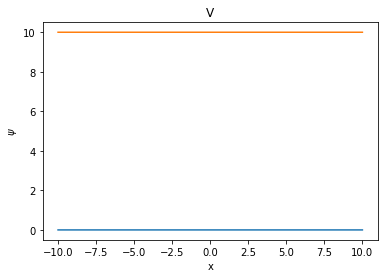

In [23]:
plt.plot(x, potential(x))
plt.title("V")
plt.xlabel("x")
plt.ylabel("V")
plt.plot(x, psi)
plt.ylabel("$\psi$")
plt.show()

Loopy?!?

In [ ]:
def tweak_psi(psi, x, amount):
    pass

In [ ]:
prev_E = 10 # the previous energy value

while numpy.abs(prev_E - E) > accuracy:
    
    #Change psi
    for pos in x:
        
        #Tweak up & tweak down
        psi_up = tweak_psi(psi, pos, +1)
        psi_down = tweak_psi(psi, pos, -1)
        
        E_up = energy_expectation(psi_up)
        E_down = energy_expectation(psi_down)
        
        diff_up = numpy.abs(prev_E - E_up)
        diff_down = numpy.abs(prev_E - E_down)
        diff_no_change = numpy.abs(prev_E - E)
        
        if diff_up < diff_down:
            E = E_up
        else:
            E= E_down
        
        prev_E = E
        E = energy_expectation(psi)
    